### Importando Bibliotecas Necessárias

In [5]:
%pip install scikit-learn
%pip install seaborn
%pip install pandas

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

random_seed = 1337

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Carregando e Formatando o Dataset (Autism-Adult-Data.arff)

In [21]:
from scipy.io.arff import loadarff

file_path = "./datasets/Autism-Adult-Data.arff"

raw_data = loadarff(file_path)
df = pandas.DataFrame(raw_data[0])

df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'0',...,b'f',b'White-European',b'no',b'no',b'United States',b'no',6.0,b'18 and more',b'Self',b'NO'
1,b'1',b'1',b'0',b'1',b'0',b'0',b'0',b'1',b'0',b'1',...,b'm',b'Latino',b'no',b'yes',b'Brazil',b'no',5.0,b'18 and more',b'Self',b'NO'
2,b'1',b'1',b'0',b'1',b'1',b'0',b'1',b'1',b'1',b'1',...,b'm',b'Latino',b'yes',b'yes',b'Spain',b'no',8.0,b'18 and more',b'Parent',b'YES'
3,b'1',b'1',b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'1',...,b'f',b'White-European',b'no',b'yes',b'United States',b'no',6.0,b'18 and more',b'Self',b'NO'
4,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',...,b'f',b'?',b'no',b'no',b'Egypt',b'no',2.0,b'18 and more',b'?',b'NO'


# Replacing byte values and correcting column name

In [22]:
def extract_string(b: bytes):
    if type(b) != float:
        return b.decode('utf-8')
    return b

df = df.rename(columns = {"austim": "autism", "contry_of_res": "country"})

df = df.applymap(lambda x: extract_string(x))

df = df.replace('1', 1)
df = df.replace('0', 0)
df = df.replace('yes', 1)
df = df.replace('no', 0)
df = df.replace('YES', 1)
df = df.replace('NO', 0)


df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,autism,country,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,0,0,United States,0,6.0,18 and more,Self,0
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,0,1,Brazil,0,5.0,18 and more,Self,0
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,1,1,Spain,0,8.0,18 and more,Parent,1
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,0,1,United States,0,6.0,18 and more,Self,0
4,1,0,0,0,0,0,0,1,0,0,...,f,?,0,0,Egypt,0,2.0,18 and more,?,0


# Removendo valores nulos

In [23]:
df = df.dropna()

# Aumentando registros de label positiva

In [24]:
df.groupby("autism")["autism"].count()

autism
0    611
1     91
Name: autism, dtype: int64

In [25]:
positive_labels = df[df["autism"] == 1]

df = pandas.concat([df, positive_labels, positive_labels])
df = df.sample(frac=1)
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,autism,country,used_app_before,result,age_desc,relation,Class/ASD
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,0,1,United States,0,6.0,18 and more,Self,0
43,0,1,1,1,0,0,0,0,0,1,...,f,White-European,1,1,United States,0,4.0,18 and more,Self,0
169,1,1,1,1,1,0,0,1,1,1,...,f,Latino,0,1,Brazil,0,8.0,18 and more,Self,1
396,1,1,1,0,1,0,0,0,0,0,...,f,Asian,0,0,United Arab Emirates,0,4.0,18 and more,Self,0
486,1,1,1,1,1,1,1,0,1,1,...,m,White-European,0,0,United Kingdom,0,9.0,18 and more,Self,1


In [26]:
df.groupby("autism")["autism"].count()


autism
0    611
1    273
Name: autism, dtype: int64

# heatmap/matriz de confusão do questionário

[[465 146]
 [144 129]]


<AxesSubplot:>

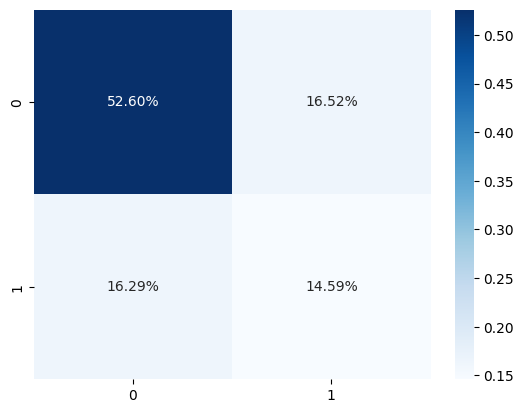

In [29]:
cf_matrix = confusion_matrix(df["autism"], df["Class/ASD"])
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

# Selecionando features úteis e label

In [30]:
useful_features = [
    "A1_Score",
    "A2_Score",
    "A3_Score",
    "A4_Score",
    "A5_Score",
    "A6_Score",
    "A7_Score",
    "A8_Score",
    "A9_Score",
    "A10_Score",
    "age",
    # "gender",
    # "ethnicity",
    "jundice",
    # "country",
    "used_app_before",
    "relation"
]

label = ["autism"]

df = df[useful_features + label]

### Dividindo o Dataset em Teste (20%) e Treino (80%)

In [31]:
data = df.iloc[:, df.columns != label[0]] 
target = df.iloc[:, -1].values
XTrain, XTest, YTrain, YTest = train_test_split(data, target, test_size=0.2, random_state=random_seed)

### Treinamento e Previsões

# Definindo otimização de parâmetros

In [32]:
def search(model, model_parameters): 
    """ """
    categorical_features = [
        "A1_Score",
        "A2_Score",
        "A3_Score",
        "A4_Score",
        "A5_Score",
        "A6_Score",
        "A7_Score",
        "A8_Score",
        "A9_Score",
        "A10_Score",
        # "gender",
        # "ethnicity",
        "jundice",
        # "country",
        "used_app_before",
        "relation"
    ]
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    model_pipeline = Pipeline([
        ('prep', preprocessor),
        ('clf', model)
    ])
    n_jobs = -1
    folds = 10

    randomized_search = GridSearchCV(
        model_pipeline,
        model_parameters,
        n_jobs=n_jobs,
        cv=folds
    )

    randomized_search.fit(XTrain, YTrain)

    return randomized_search

In [33]:
dt_parameters = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__splitter": ["best", "random"],
    "clf__max_depth": range(3, 50),
    "clf__min_samples_split": range(2, 10)
}

dt_gridsearch = search(DecisionTreeClassifier(random_state=random_seed), dt_parameters)
dt_best_score = dt_gridsearch.best_score_
dt_best_params = dt_gridsearch.best_params_

print(f"Best score on the decision tree otimization: {dt_best_score}")
print("Best params:")
for key, value in dt_best_params.items():
    print(f"{key}: {value}")

Best score on the decision tree otimization: 0.7864386317907444
Best params:
clf__criterion: entropy
clf__max_depth: 12
clf__min_samples_split: 2
clf__splitter: best


### Avaliando a Decision tree otimizada

[[106  19]
 [ 12  40]]


<AxesSubplot:>

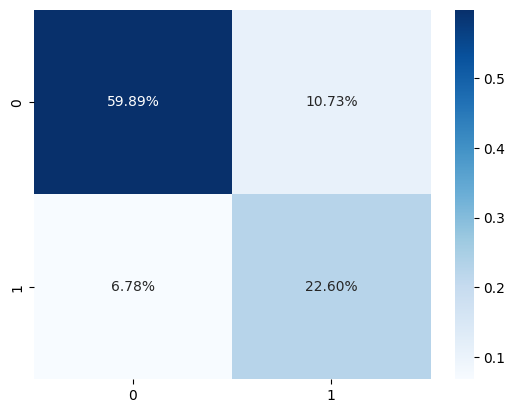

In [34]:
dt = dt_gridsearch.best_estimator_

y_pred = dt.predict(XTest)

cf_matrix = confusion_matrix(YTest, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

<AxesSubplot:>

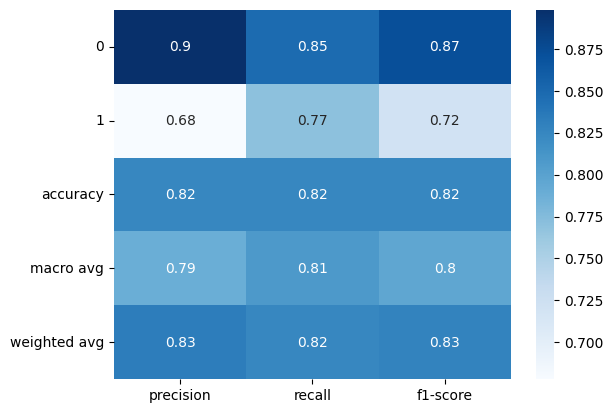

In [35]:
# RESULTADOS 1
clf_report1 = classification_report(YTest, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T, annot=True, cmap='Blues')

# Features mais relevantes para Decision Tree

30 30
Feature Importances:


<AxesSubplot:xlabel='feature', ylabel='importance'>

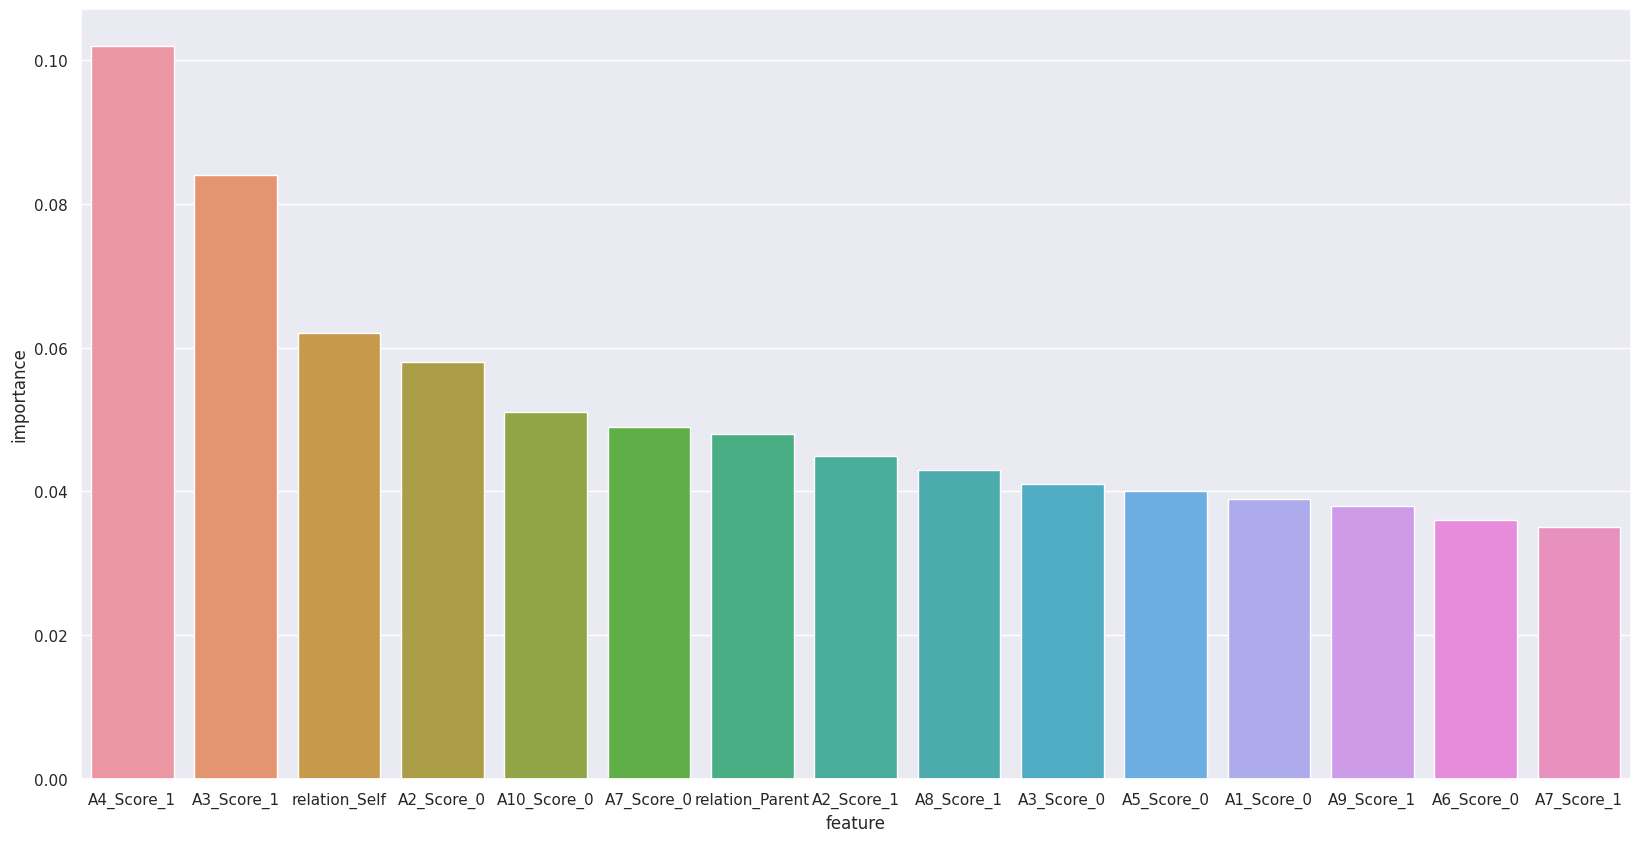

In [41]:
features = dt.named_steps["prep"].transformers_[0][1].steps[0][1].get_feature_names_out()
importances = dt.steps[1][1].feature_importances_

print(len(features), len(importances))

print("Feature Importances:")
feature_importances = []
for i, feature in enumerate(features):
    feature_importances.append({
        "feature": feature,
        "importance": round(importances[i], 3)
    })

feature_importances = sorted(feature_importances, key=lambda x: x["importance"], reverse=True)
feature_importances = feature_importances[:15]

sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(data=pandas.DataFrame(feature_importances), x="feature", y="importance")

# Decision Tree

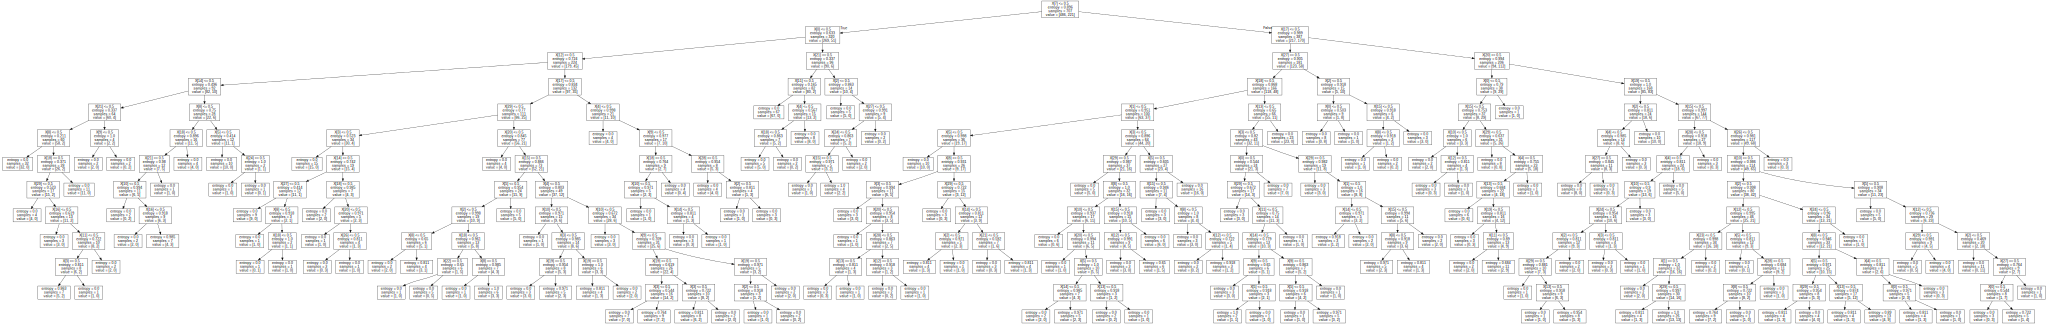

In [42]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(dt.steps[1][1], out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)